In [2]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
import astropy as ast
from astropy import stats

import SessionTools.two_photon as st2p


plt.rcParams['pdf.fonttype']=42

%load_ext autoreload
%autoreload 2 


%matplotlib inline


In [3]:
basedir = pathlib.Path('/media/mplitt/SSD_storage/2P_scratch/R18B05LexA_CsChrimsontdT_R60D05Gal4_jGCaMP7f/remapping')
sess_df = pd.read_csv(basedir / 'sessions.csv')
sess_df = sess_df.iloc[:-1]
print(sess_df.columns)
sess_df['fly_id'] = [row['date']+'_'+row['fly'] +'_' + row['condition'] for _, row in sess_df.iterrows()]
sess_df['mean offset'] = [np.nan for _, row in sess_df.iterrows()]
sess_df['offset var.'] = [np.nan for _, row in sess_df.iterrows()]
sess_df['mean vec. len'] = [np.nan for _, row in sess_df.iterrows()]


figfolder = pathlib.Path('/media/mplitt/SSD_storage/fig_scratch/LabMeetings/05_09_2024/R18B05LexA_CsChrimsontdT_R60D05Gal4_jGCaMP7f')
figfolder.mkdir(parents=True, exist_ok=True)

Index(['date', 'fly', 'sess', 'fictrac_scan_num', 'fictrac_file', 'condition',
       'scan_type', 'usable', 'notes'],
      dtype='object')


In [4]:
sess_df.head()

,date,fly,sess,fictrac_scan_num,fictrac_file,condition,scan_type,usable,notes,fly_id,mean offset,offset var.,mean vec. len
0,11_07_2024,fly1,baseline-000,0,fictrac-20240711_112205.dat,remap,baseline,NaN,NaN,11_07_2024_fly1_remap,NaN,NaN,NaN
1,11_07_2024,fly1,remap_0deg-001,1,fictrac-20240711_112205.dat,remap,remap_0deg,NaN,NaN,11_07_2024_fly1_remap,NaN,NaN,NaN
2,11_07_2024,fly1,post_0deg-002,2,fictrac-20240711_112205.dat,remap,post_0deg,NaN,NaN,11_07_2024_fly1_remap,NaN,NaN,NaN
3,11_07_2024,fly1,remap_180deg-004,4,fictrac-20240711_112205.dat,remap,remap_180deg,NaN,NaN,11_07_2024_fly1_remap,NaN,NaN,NaN
4,11_07_2024,fly1,post_180deg-006,6,fictrac-20240711_112205.dat,remap,post_180deg,NaN,NaN,11_07_2024_fly1_remap,NaN,NaN,NaN


In [7]:
for index,row in sess_df.iterrows():
    outdir = pathlib.PurePath( basedir / row['condition'] / row['date'] / row['fly'] / row['sess'] / 'preprocess.pkl')
    pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
    dff = pp.calculate_zscored_F('rois', exp_detrend=True, zscore=True, background_ts='background')[-1,:,:]
    dff = sp.ndimage.gaussian_filter1d(sp.ndimage.gaussian_filter1d(dff, 1, axis=-1),.5,axis=0, mode='wrap')
    
    heading = np.angle(np.exp(1j*(-1*pp.voltage_recording_aligned[' Heading'].to_numpy()-np.pi)))
    h_mask = np.abs(heading)<3*np.pi/4
        
        
    x_f,y_f = st2p.utilities.pol2cart(dff ,np.linspace(-np.pi,np.pi,num=dff.shape[0])[:,np.newaxis])
    rho,phi = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0))

    _,offset = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi-heading))
    # print(offset.shape)
    
    
    x_o, y_o = st2p.utilities.pol2cart(np.ones(heading[h_mask].shape), offset[h_mask])
    r, offset_mu = st2p.utilities.cart2pol(x_o.mean(), y_o.mean())
    
    sess_df.loc[index, 'mean offset'] = offset_mu
    sess_df.loc[index, 'mean vec. len'] = r
    sess_df.loc[index, 'offset var.'] = sp.stats.circvar(offset[h_mask])


In [8]:
def make_condition_dataframe(df, scan_types = ['baseline', 'post_0deg', 'post_180deg']):
    flies = df['fly_id'].unique()
    
    cond_df = {'fly':[]}
    for st in scan_types:
        cond_df.update({f'{st}_mu':[],
                        f'{st}_var':[],
                        f'{st}_r':[],
                       })
        
    for fly in flies:
        
        cond_df['fly'].append(fly)
        
        for st in scan_types:
            sub_df = df.loc[(df['fly_id']==fly) & (df['scan_type']==st)]
            cond_df[f'{st}_mu'].append(sub_df['mean offset'].mean())
            cond_df[f'{st}_var'].append(sub_df['offset var.'].mean())
            cond_df[f'{st}_r'].append(sub_df['mean vec. len'].mean())

    return pd.DataFrame(cond_df)

In [9]:
remap_sess_df = sess_df[sess_df['condition']=='remap']
remap_data = make_condition_dataframe(remap_sess_df)


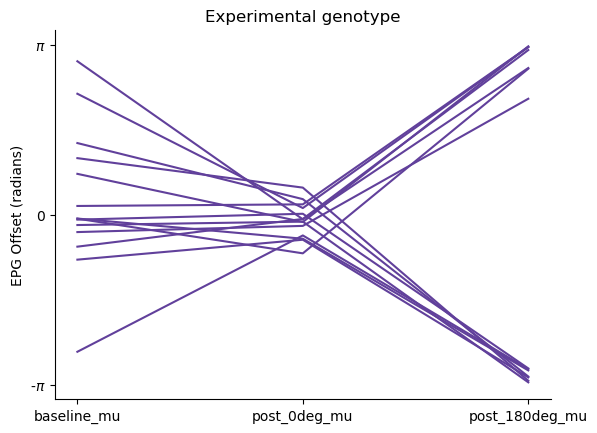

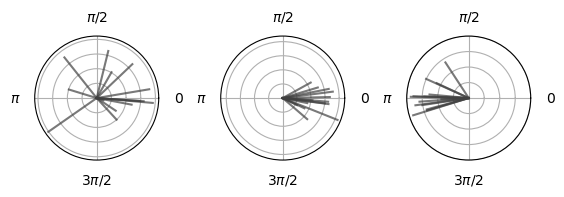

In [13]:
fig, ax= plt.subplots()

_ = ax.plot(remap_data[['baseline_mu','post_0deg_mu','post_180deg_mu']].T, color=plt.cm.Purples(.8))
ax.set_ylabel('EPG Offset (radians)')
ax.set_title('Experimental genotype')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks([-np.pi, 0, np.pi], labels=[r'-$\pi$', 0, r'$\pi$'])
fig.savefig(figfolder / "EL_remap.pdf")

fig, ax = plt.subplots(1,3,subplot_kw={'projection': 'polar'})
fig.subplots_adjust(wspace=.5)
for index,row in remap_data.iterrows():
    ax[0].plot(row['baseline_mu']*np.ones([2,]), [0, row['baseline_r']], color=plt.cm.Greys(.8), alpha=.7)
    ax[1].plot(row['post_0deg_mu']*np.ones([2,]), [0, row['post_0deg_r']], color=plt.cm.Greys(.8), alpha=.7)
    ax[2].plot(row['post_180deg_mu']*np.ones([2,]), [0, row['post_180deg_r']], color=plt.cm.Greys(.8), alpha=.7)


    
for a in ax:
    a.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2], ['0', r'$\pi$/2', r'$\pi$', r'3$\pi$/2'])
    a.set_yticks([0,.2,.4,.6,.8],['','','','',''])

In [ ]:
# controls

In [ ]:
# summary scatter plots

In [ ]:
# plot every session

In [ ]:
# EL excites EPG, dangling in the dark data

